## Compare three types of models
#### LinearRegression, Tree-based, and time-series models

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib

In [2]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (119150, 31)


In [3]:
# load models
lr_path = '../models/lr_models_log.pkl'
tree_path = '../models/tree_models.pkl'
sarimax_path = '../models/sarimax_results.pkl'
lr_res = joblib.load(lr_path)
tree_res = joblib.load(tree_path)
sarimax_res = joblib.load(sarimax_path)

# Print model names
print("Loaded models:")
print(f" - Linear Regression: {lr_res.keys()}")
print(f" - Decision Tree: {tree_res.keys()}")
print(f" - SARIMAX: {sarimax_res['Config'].unique()}")

Loaded models:
 - Linear Regression: dict_keys(['lr_base', 'lr_base_lags', 'lr_full', 'lr_cyc', 'lr_cyc_lags', 'lr_evt', 'ridge_full', 'lasso_full'])
 - Decision Tree: dict_keys(['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_cyc_lags', 'rf_full', 'gbrt_base', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags', 'gbrt_full'])
 - SARIMAX: ['base' 'evt_total' 'evt' 'cyc' 'full']


In [4]:
# Set up training and testing data

# =====Choose target and exogenous variables=====
TARGET_COL = 'travel_time_seconds'
TMC = '115+04187'
CONFIG_NAME = 'full'  # 'base', 'evt_total', 'evt', 'cyc', 'full'
# =============================================

grp = X_full.xs(TMC, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')
# tmc_miles = grp['miles'].iloc[0]
n_test = int(len(grp) * 0.2)
y_train = grp[TARGET_COL].iloc[:-n_test].values
y_test  = grp[TARGET_COL].iloc[-n_test:].values

# print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

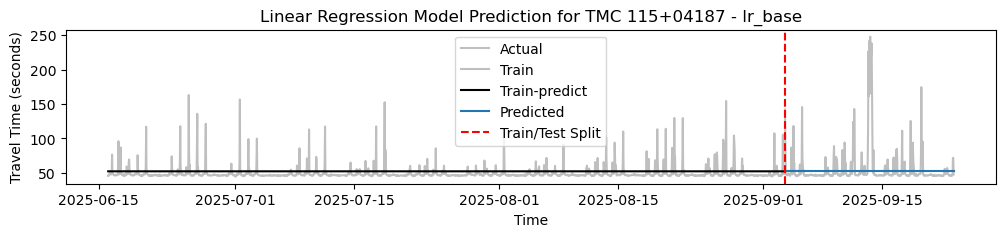

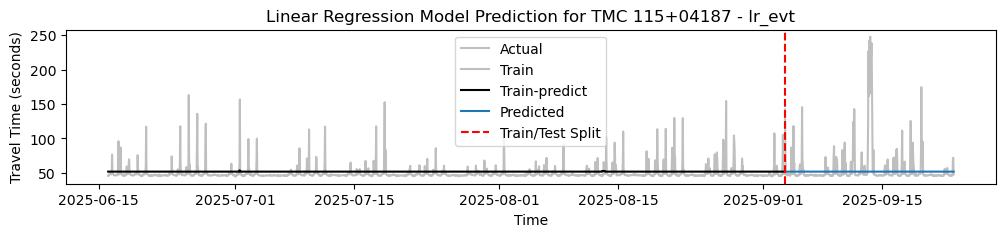

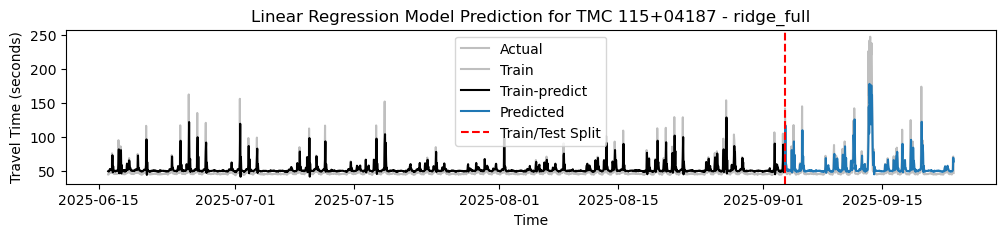

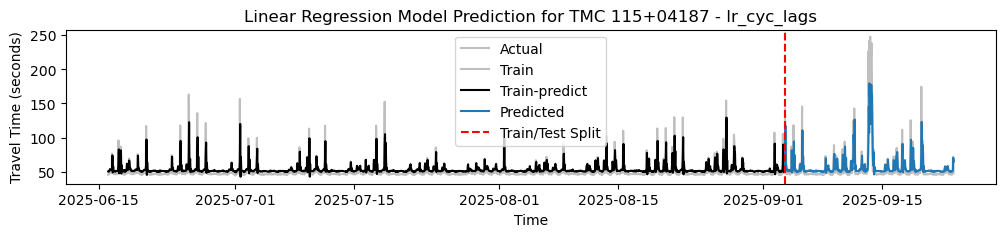

In [5]:
# Visualize lr model predictions
CANDIDATES = ['lr_base',  'lr_evt', 'ridge_full','lr_cyc_lags']
# time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
# evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
# lag_features = ['lag1', 'lag2', 'lag3']
# tmc_features = ['miles']
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed']
full_features = time_features + evt_features + lag_features + tmc_features

regressors = {
    'base': tmc_features,
    'base_lags': tmc_features + lag_features,
    'full': full_features,
    'cyc':  time_features + tmc_features,
    'cyc_lags':  time_features + tmc_features + lag_features,
    'evt': evt_features + tmc_features,
    'evt_lags':evt_features + tmc_features + lag_features,
}

for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in lr_res:
        model = lr_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Linear Regression models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Linear Regression Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

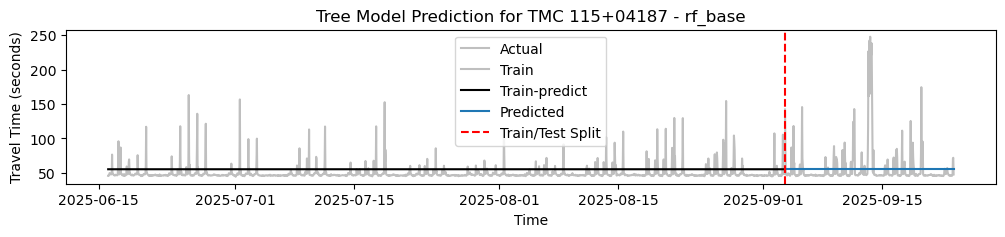

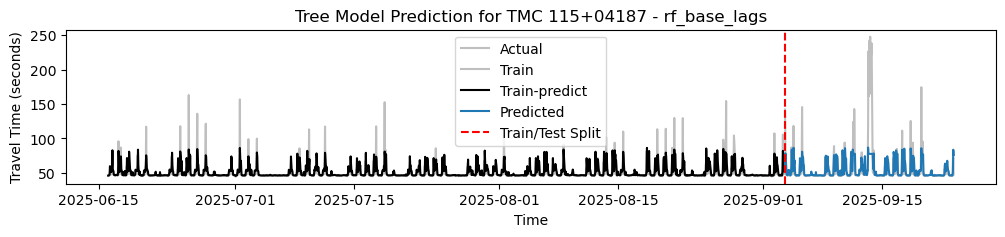

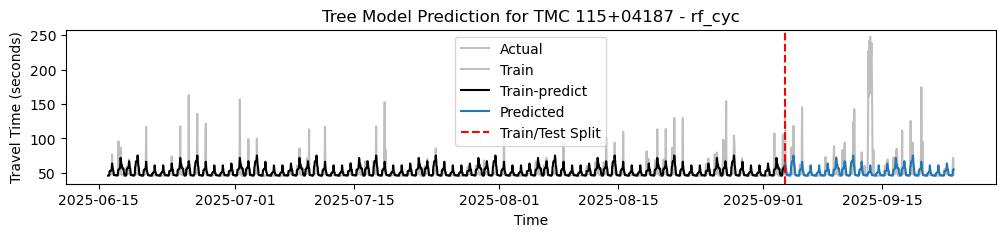

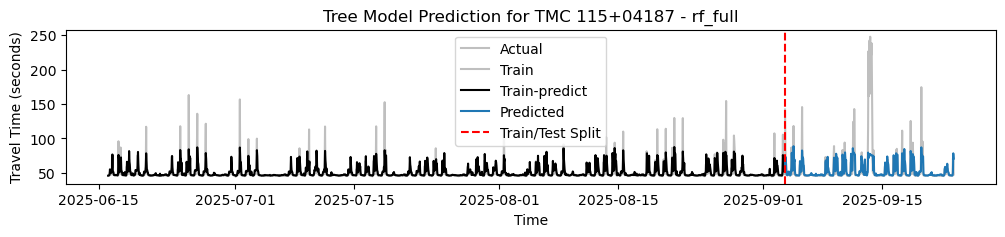

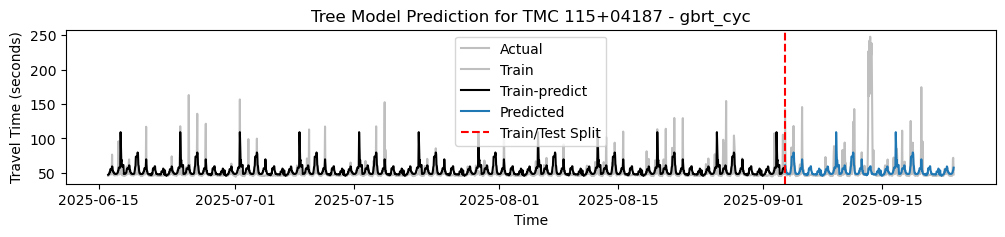

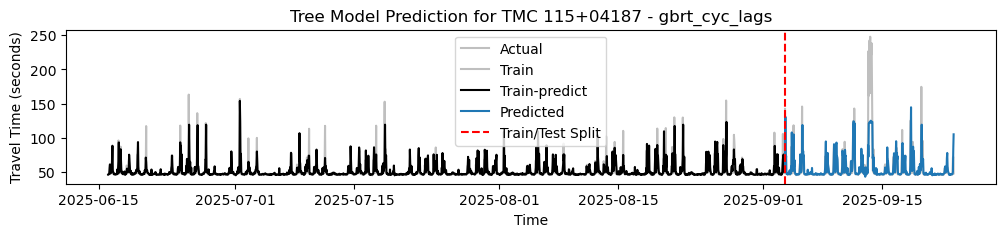

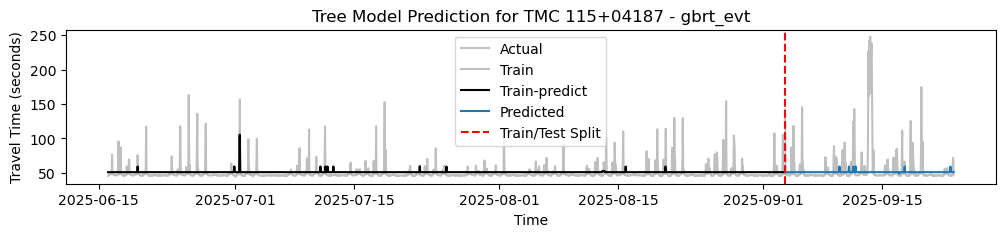

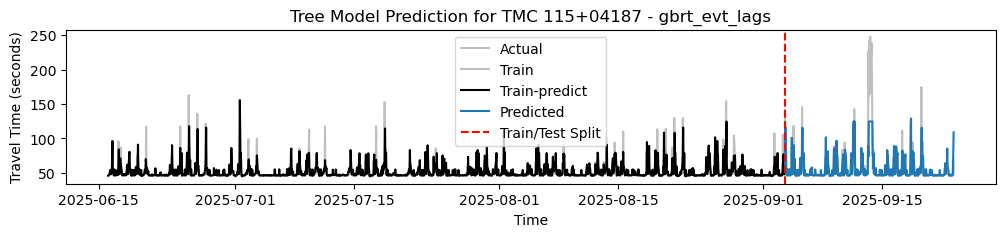

In [21]:
# Visualize tree model predictions`
CANDIDATES = ['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_full', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags']
for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in tree_res:
        model = tree_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Tree models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Tree Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

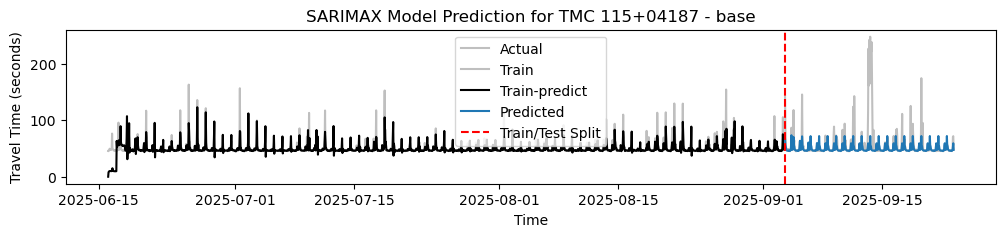

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


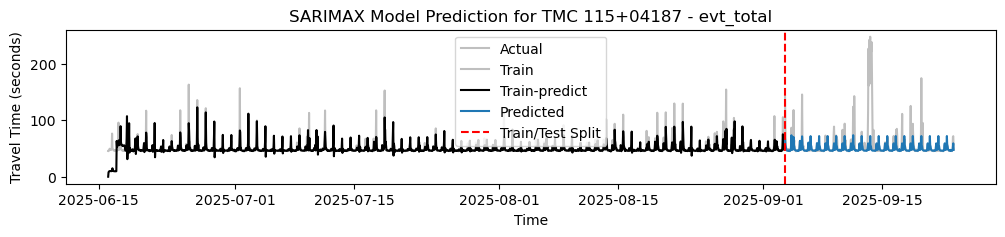

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


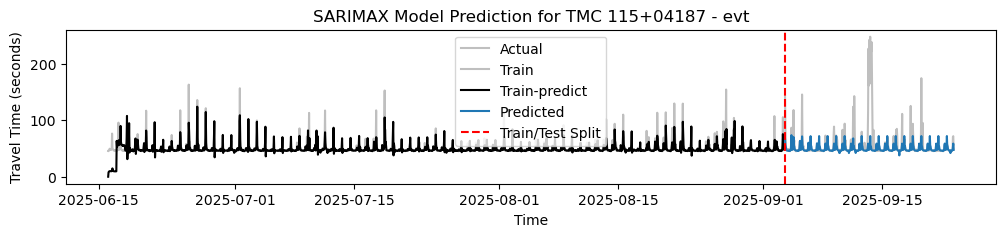

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


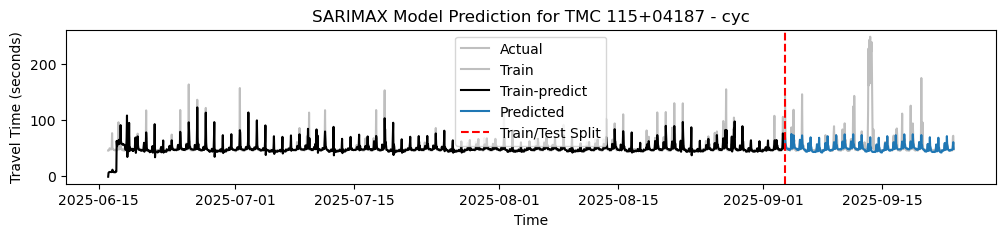

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


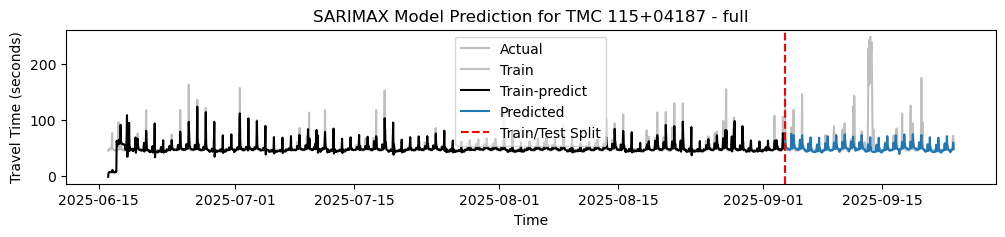

In [43]:
# Visualize time-series model predictions
# Fitting models on the fly will take some time
CANDIDATES = ['base', 'evt_total', 'evt', 'cyc', 'full']
exog_features = {
    "base": None,
    "evt_total": ["evt_total"],
    "evt": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc'],
    "cyc": ['hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend'],
    "full": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc',
            'hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend']
}
# exog_cols = exog_features[CONFIG_NAME]

for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    if candidate in sarimax_res['Config'].values:
        
        exog = exog_features[candidate]
        if exog is None:
            X_train = None
            X_test = None
        else:
            X_train = grp[exog].iloc[:-n_test]
            X_test  = grp[exog].iloc[-n_test:]

        model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(1,1,1,24),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        pred_in = results.fittedvalues
        pred = results.get_forecast(steps=n_test, exog=X_test).predicted_mean

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded SARIMAX models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'SARIMAX Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()